# Plagiarism Detector
In this notebook, I examine text files to perform data classification. Each file is labeled as either plagiarized or not.
The notebook was created to be used in **AWS Sagemaker** environment.

## Download data and save locally

Source for database: 

Clough, P. and Stevenson, M. Developing A Corpus of Plagiarised Short Answers, Language Resources and Evaluation: Special Issue on Plagiarism and Authorship Analysis, In Press. [Download]

In [1]:
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c4147f9_data/data.zip
!unzip data

--2021-03-23 13:58:44--  https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c4147f9_data/data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.184.189
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.184.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113826 (111K) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>] 111.16K  --.-KB/s    in 0.03s   

2021-03-23 13:58:45 (3.23 MB/s) - ‘data.zip.1’ saved [113826/113826]

Archive:  data.zip
   creating: data/
  inflating: data/.DS_Store          
   creating: __MACOSX/
   creating: __MACOSX/data/
  inflating: __MACOSX/data/._.DS_Store  
  inflating: data/file_information.csv  
  inflating: __MACOSX/data/._file_information.csv  
  inflating: data/g0pA_taska.txt     
  inflating: __MACOSX/data/._g0pA_taska.txt  
  inflating: data/g0pA_taskb.txt     
  inflating: __MACOSX/data/._g0pA_taskb.txt  
  inflating: data/g0pA_taskc.txt     
  infl

In [3]:
# import libraries
import pandas as pd
import numpy as np
import os

This plagiarism dataset is made of multiple text files; each of these files has characteristics that are is summarized in a .csv file named file_information.csv, which we can read in using pandas.

In [4]:
csv_file = 'data/file_information.csv'
plagiarism_df = pd.read_csv(csv_file)

# print out the first few rows of data info
plagiarism_df.head(10)

,File,Task,Category
0,g0pA_taska.txt,a,non
1,g0pA_taskb.txt,b,cut
2,g0pA_taskc.txt,c,light
3,g0pA_taskd.txt,d,heavy
4,g0pA_taske.txt,e,non
5,g0pB_taska.txt,a,non
6,g0pB_taskb.txt,b,non
7,g0pB_taskc.txt,c,cut
8,g0pB_taskd.txt,d,light
9,g0pB_taske.txt,e,heavy


(Text extracted from original source)
### Five task types, A-E
Each text file contains an answer to one short question; these questions are labeled as tasks A-E.

- Each task, A-E, is about a topic that might be included in the Computer Science curriculum that was created by the authors of this dataset.
- For example, Task A asks the question: "What is inheritance in object oriented programming?"

Four categories of plagiarism
Each text file has an associated plagiarism label/category:

- `cut`: An answer is plagiarized; it is copy-pasted directly from the relevant Wikipedia source text.
- `light`: An answer is plagiarized; it is based on the Wikipedia source text and includes some copying and paraphrasing.
- `heavy`: An answer is plagiarized; it is based on the Wikipedia source text but expressed using different words and structure. Since this doesn't copy directly from a source text, this will likely be the most challenging kind of plagiarism to detect.
- `non`: An answer is not plagiarized; the Wikipedia source text is not used to create this answer.
- `orig`: This is a specific category for the original, Wikipedia source text. Files for comparison purposes  only.

### Data visualization and analysis

In [5]:
# print out some stats about the data
print('Number of files: ', plagiarism_df.shape[0])  # .shape[0] gives the rows 
# .unique() gives unique items in a specified column
print('Number of unique tasks/question types (A-E): ', (len(plagiarism_df['Task'].unique())))
print('Unique plagiarism categories: ', (plagiarism_df['Category'].unique()))

Number of files:  100
Number of unique tasks/question types (A-E):  5
Unique plagiarism categories:  ['non' 'cut' 'light' 'heavy' 'orig']


In [6]:
# Show counts by different tasks and amounts of plagiarism

# group and count by task
counts_per_task = plagiarism_df.groupby(['Task']).size().reset_index(name="Counts")
print("\nTask:")
display(counts_per_task)

# group by plagiarism level
counts_per_category = plagiarism_df.groupby(['Category']).size().reset_index(name="Counts")
print("\nPlagiarism Levels:")
display(counts_per_category)

# group by task AND plagiarism level
counts_task_and_plagiarism = plagiarism_df.groupby(['Task', 'Category']).size().reset_index(name="Counts")
print("\nTask & Plagiarism Level Combos :")
display(counts_task_and_plagiarism)


Task:


,Task,Counts
0,a,20
1,b,20
2,c,20
3,d,20
4,e,20



Plagiarism Levels:


,Category,Counts
0,cut,19
1,heavy,19
2,light,19
3,non,38
4,orig,5



Task & Plagiarism Level Combos :


,Task,Category,Counts
0,a,cut,4
1,a,heavy,3
2,a,light,3
3,a,non,9
4,a,orig,1
5,b,cut,3
6,b,heavy,4
7,b,light,3
8,b,non,9
9,b,orig,1


<BarContainer object of 25 artists>

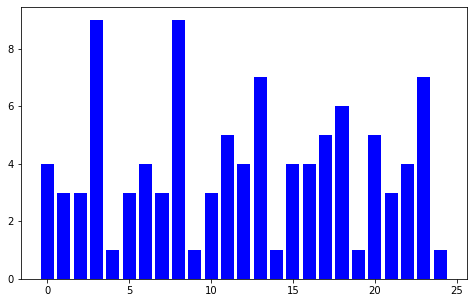

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# counts
group = ['Task', 'Category']
counts = plagiarism_df.groupby(group).size().reset_index(name="Counts")

plt.figure(figsize=(8,5))
plt.bar(range(len(counts)), counts['Counts'], color = 'blue')

## Feature Engineering
Tasks: 
- Clean and pre-process the data.
- Define features for comparing the similarity of an answer text and a source text, and extract similarity features.
- Select "good" features, by analyzing the correlations between different features.
- Create train/test .csv files that hold the relevant features and class labels for train/test data points

In [8]:
# import extra library
from sklearn.feature_extraction.text import CountVectorizer

### Convert categorical to numerical data

Two columns will be created to provide a numerical value for each of the samples. 
They are:
- `Category`: labels to numerical labels according to the following rules (a higher value indicates a higher degree of plagiarism):
    * 0 = non;
    * 1 = heavy;
    * 2 = light;
    * 3 = cut;
    * -1 = orig, this is a special value that indicates an original file.
- `Class`: Any answer text that is not plagiarized (non) should have the class label 0. Any plagiarized answer texts should have the class label 1.
And any orig texts will have a special label -1.

In [9]:
# Read in a csv file and return a transformed dataframe
def numerical_dataframe(csv_file='data/file_information.csv'):
    '''Reads in a csv file which is assumed to have `File`, `Category` and `Task` columns.
       This function does two things: 
       1) converts `Category` column values to numerical values 
       2) Adds a new, numerical `Class` label column.
       The `Class` column will label plagiarized answers as 1 and non-plagiarized as 0.
       Source texts have a special label, -1.
       :param csv_file: The directory for the file_information.csv file
       :return: A dataframe with numerical categories and a new `Class` label column'''
    
    # your code here
    df = pd.read_csv(csv_file)
    category_conversion = {
        'non': 0,
        'heavy': 1,
        'light': 2,
        'cut': 3, 
        'orig': -1
    }

    df["Category"] = df["Category"].apply(lambda x: category_conversion[x])
    df["Class"] = df["Category"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    
    return df

In [10]:
# informal testing, print out the results of a called function
# create new `transformed_df`
transformed_df = numerical_dataframe(csv_file ='data/file_information.csv')

# check work
# check that all categories of plagiarism have a class label = 1
transformed_df.head()

,File,Task,Category,Class
0,g0pA_taska.txt,a,0,0
1,g0pA_taskb.txt,b,3,1
2,g0pA_taskc.txt,c,2,1
3,g0pA_taskd.txt,d,1,1
4,g0pA_taske.txt,e,0,0


### Text processing and data spliting

Two new columns will be created:
* A Text column; this holds all the lowercase text for a File, with extraneous punctuation removed.
* A Datatype column; this is a string value train, test, or orig that labels a data point as part of our train or test set

In [11]:
import re
# helper function for pre-processing text given a file
def process_file(file):
    # put text in all lower case letters 
    all_text = file.read().lower()

    # remove all non-alphanumeric chars
    all_text = re.sub(r"[^a-zA-Z0-9]", " ", all_text)
    # remove newlines/tabs, etc. so it's easier to match phrases, later
    all_text = re.sub(r"\t", " ", all_text)
    all_text = re.sub(r"\n", " ", all_text)
    all_text = re.sub("  ", " ", all_text)
    all_text = re.sub("   ", " ", all_text)
    
    return all_text

In [12]:
# create a text column 
def create_text_column(df, file_directory='data/'):
    '''Reads in the files, listed in a df and returns that df with an additional column, `Text`. 
       :param df: A dataframe of file information including a column for `File`
       :param file_directory: the main directory where files are stored
       :return: A dataframe with processed text '''
   
    # create copy to modify
    text_df = df.copy()
    
    # store processed text
    text = []
    
    # for each file (row) in the df, read in the file 
    for row_i in df.index:
        filename = df.iloc[row_i]['File']
        #print(filename)
        file_path = file_directory + filename
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:

            # standardize text using helper function
            file_text = process_file(file)
            # append processed text to list
            text.append(file_text)
    
    # add column to the copied dataframe
    text_df['Text'] = text
    
    return text_df


text_df = create_text_column(transformed_df)
text_df.head()

,File,Task,Category,Class,Text
0,g0pA_taska.txt,a,0,0,inheritance is a basic concept of object orien...
1,g0pA_taskb.txt,b,3,1,pagerank is a link analysis algorithm used by ...
2,g0pA_taskc.txt,c,2,1,the vector space model also called term vector...
3,g0pA_taskd.txt,d,1,1,bayes theorem was names after rev thomas bayes...
4,g0pA_taske.txt,e,0,0,dynamic programming is an algorithm design tec...


In [13]:
# Use function to label datatype for training 1 or test 2 
def create_datatype(df, train_value, test_value, datatype_var, compare_dfcolumn, operator_of_compare, value_of_compare,
                    sampling_number, sampling_seed):
    # Subsets dataframe by condition relating to statement built from:
    # 'compare_dfcolumn' 'operator_of_compare' 'value_of_compare'
    df_subset = df[operator_of_compare(df[compare_dfcolumn], value_of_compare)]
    df_subset = df_subset.drop(columns = [datatype_var])
    
    # Prints counts by task and compare_dfcolumn for subset df
    #print("\nCounts by Task & " + compare_dfcolumn + ":\n", df_subset.groupby(['Task', compare_dfcolumn]).size().reset_index(name="Counts") )
    
    # Sets all datatype to value for training for df_subset
    df_subset.loc[:, datatype_var] = train_value
    
    # Performs stratified random sample of subset dataframe to create new df with subset values 
    df_sampled = df_subset.groupby(['Task', compare_dfcolumn], group_keys=False).apply(lambda x: x.sample(min(len(x), sampling_number), random_state = sampling_seed))
    df_sampled = df_sampled.drop(columns = [datatype_var])
    # Sets all datatype to value for test_value for df_sampled
    df_sampled.loc[:, datatype_var] = test_value
    
    # Prints counts by compare_dfcolumn for selected sample
    #print("\nCounts by "+ compare_dfcolumn + ":\n", df_sampled.groupby([compare_dfcolumn]).size().reset_index(name="Counts") )
    #print("\nSampled DF:\n",df_sampled)
    
    # Labels all datatype_var column as train_value which will be overwritten to 
    # test_value in next for loop for all test cases chosen with stratified sample
    for index in df_sampled.index: 
        # Labels all datatype_var columns with test_value for straified test sample
        df_subset.loc[index, datatype_var] = test_value

    #print("\nSubset DF:\n",df_subset)
    # Adds test_value and train_value for all relevant data in main dataframe
    for index in df_subset.index:
        # Labels all datatype_var columns in df with train_value/test_value based upon 
        # stratified test sample and subset of df
        df.loc[index, datatype_var] = df_subset.loc[index, datatype_var]

    # returns nothing because dataframe df already altered 

In [14]:
import operator 
# create new df with Datatype (train, test, orig) column
def train_test_dataframe(clean_df, random_seed=100):
    new_df = clean_df.copy()
    # Initialize datatype as 0 initially for all records - after function 0 will remain only for original wiki answers
    new_df.loc[:,'Datatype'] = 0
    # Creates test & training datatypes for plagiarized answers (1,2,3)
    create_datatype(new_df, 1, 2, 'Datatype', 'Category', operator.gt, 0, 1, random_seed)
    # Creates test & training datatypes for NON-plagiarized answers (0)
    create_datatype(new_df, 1, 2, 'Datatype', 'Category', operator.eq, 0, 2, random_seed)
    # creating a dictionary of categorical:numerical mappings for plagiarsm categories
    mapping = {0:'orig', 1:'train', 2:'test'} 
    # traversing through dataframe and replacing categorical data
    new_df.Datatype = [mapping[item] for item in new_df.Datatype] 
    return new_df


random_seed = 1 # can change; set for reproducibility

# pass in `text_df` from above to create a complete dataframe, with all the information you need
complete_df = train_test_dataframe(text_df, random_seed=random_seed)

# check results
complete_df.head(20)

,File,Task,Category,Class,Text,Datatype
0,g0pA_taska.txt,a,0,0,inheritance is a basic concept of object orien...,train
1,g0pA_taskb.txt,b,3,1,pagerank is a link analysis algorithm used by ...,test
2,g0pA_taskc.txt,c,2,1,the vector space model also called term vector...,train
3,g0pA_taskd.txt,d,1,1,bayes theorem was names after rev thomas bayes...,train
4,g0pA_taske.txt,e,0,0,dynamic programming is an algorithm design tec...,train
5,g0pB_taska.txt,a,0,0,inheritance is a basic concept in object orien...,train
6,g0pB_taskb.txt,b,0,0,pagerank pr refers to both the concept and the...,train
7,g0pB_taskc.txt,c,3,1,vector space model is an algebraic model for r...,test
8,g0pB_taskd.txt,d,2,1,bayes theorem relates the conditional and marg...,train
9,g0pB_taske.txt,e,1,1,dynamic programming is a method for solving ma...,test


### Similarity features
One of the ways we might go about detecting plagiarism, is by computing similarity features that measure how similar a given answer text is as compared to the original wikipedia source text (for a specific task, a-e). The similarity features are informed by [this paper on plagiarism detection](https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c412841_developing-a-corpus-of-plagiarised-short-answers/developing-a-corpus-of-plagiarised-short-answers.pdf).
In this paper, researchers created features called __containment__ and __longest common subsequence__.

#### Containment calculation

The general steps to complete this function are as follows:

1. From all of the text files in a given df, create an array of n-gram counts; it is suggested that you use a CountVectorizer for this purpose.
2. Get the processed answer and source texts for the given answer_filename.
3. Calculate the containment between an answer and source text according to the following equation.

$$ \frac{\sum{count(\text{ngram}_{A}) \cap count(\text{ngram}_{S})}}{\sum{count(\text{ngram}_{A})}} $$

4. Return that containment value.


In [15]:
# Calculate the ngram containment for one answer file/source file pair in a df
def calculate_containment(df, n, answer_filename):
    '''Calculates the containment between a given answer text and its associated source text.
       This function creates a count of ngrams (of a size, n) for each text file in our data.
       Then calculates the containment by finding the ngram count for a given answer text, 
       and its associated source text, and calculating the normalized intersection of those counts.
       :param df: A dataframe with columns,
           'File', 'Task', 'Category', 'Class', 'Text', and 'Datatype'
       :param n: An integer that defines the ngram size
       :param answer_filename: A filename for an answer text in the df, ex. 'g0pB_taskd.txt'
       :return: A single containment value that represents the similarity
           between an answer text and its source text.
    '''

    source_filename = 'orig_' + answer_filename.split('_')[1]
    answer_text = df[df['File'] == answer_filename].iloc[0]['Text']
    source_text = df[df['File'] == source_filename].iloc[0]['Text']
  
    cv = CountVectorizer(ngram_range=(n,n))
    matrix = cv.fit_transform([answer_text, source_text]).toarray()
    
    intersection = np.min(matrix, 0)
    
    return sum(intersection)/sum(matrix[0])

#### Test cells

In [16]:
# select a value for n
n = 3

# indices for first few files
test_indices = range(5)

# iterate through files and calculate containment
category_vals = []
containment_vals = []
for i in test_indices:
    # get level of plagiarism for a given file index
    category_vals.append(complete_df.loc[i, 'Category'])
    # calculate containment for given file and n
    filename = complete_df.loc[i, 'File']
    c = calculate_containment(complete_df, n, filename)
    containment_vals.append(c)

# print out result, does it make sense?
print('Original category values: \n', category_vals)
print()
print(str(n)+'-gram containment values: \n', containment_vals)

Original category values: 
 [0, 3, 2, 1, 0]

3-gram containment values: 
 [0.009345794392523364, 0.9641025641025641, 0.6136363636363636, 0.15675675675675677, 0.031746031746031744]


#### Longest Common Subsequence

It may be helpful to think of this in a concrete example. A Longest Common Subsequence (LCS) problem may look as follows:

* Given two texts: text A (answer text) of length n, and string S (original source text) of length m. Our goal is to produce their longest common subsequence of words: the longest sequence of words that appear left-to-right in both texts (though the words don't have to be in continuous order).
* Consider:

    * A = "i think pagerank is a link analysis algorithm used by google that uses a system of weights attached to each element of a hyperlinked set of documents"
    * S = "pagerank is a link analysis algorithm used by the google internet search engine that assigns a numerical weighting to each element of a hyperlinked set of documents"
- In this case, we can see that the start of each sentence of fairly similar, having overlap in the sequence of words, "pagerank is a link analysis algorithm used by" before diverging slightly. Then we continue moving left -to-right along both texts until we see the next common sequence; in this case it is only one word, "google". Next we find "that" and "a" and finally the same ending "to each element of a hyperlinked set of documents".

In [17]:
# Compute the normalized LCS given an answer text and a source text
def lcs_norm_word(answer_text, source_text):
    '''Computes the longest common subsequence of words in two texts; returns a normalized value.
       :param answer_text: The pre-processed text for an answer text
       :param source_text: The pre-processed text for an answer's associated source text
       :return: A normalized LCS value'''
    
    answer_words = [''] + answer_text.split()
    source_words = [''] + source_text.split()
    
    # Prepare matrix for Dynamic Programmaing
    matrix = np.zeros((len(answer_words), len(source_words)))
    
    for i in range(1, len(answer_words)):
        for j in range(1, len(source_words)):
            matrix[i][j] = (matrix[i-1][j-1] + 1) if (source_words[j] == answer_words[i]) else max(matrix[i-1][j], matrix[i][j-1])
          
    return matrix[-1,-1] / (len(answer_words) - 1)

#### Test cells

In [18]:
# Run the test scenario from above
# does your function return the expected value?

A = "i think pagerank is a link analysis algorithm used by google that uses a system of weights attached to each element of a hyperlinked set of documents"
S = "pagerank is a link analysis algorithm used by the google internet search engine that assigns a numerical weighting to each element of a hyperlinked set of documents"

# calculate LCS
lcs = lcs_norm_word(A, S)
print('LCS = ', lcs)


# expected value test
assert lcs==20/27., "Incorrect LCS value, expected about 0.7408, got "+str(lcs)

print('Test passed!')

LCS =  0.7407407407407407
Test passed!


In [19]:
# test on your own
test_indices = range(5) # look at first few files

category_vals = []
lcs_norm_vals = []
# iterate through first few docs and calculate LCS
for i in test_indices:
    category_vals.append(complete_df.loc[i, 'Category'])
    # get texts to compare
    answer_text = complete_df.loc[i, 'Text'] 
    task = complete_df.loc[i, 'Task']
    # we know that source texts have Class = -1
    orig_rows = complete_df[(complete_df['Class'] == -1)]
    orig_row = orig_rows[(orig_rows['Task'] == task)]
    source_text = orig_row['Text'].values[0]
    
    # calculate lcs
    lcs_val = lcs_norm_word(answer_text, source_text)
    lcs_norm_vals.append(lcs_val)

# print out result, does it make sense?
print('Original category values: \n', category_vals)
print()
print('Normalized LCS values: \n', lcs_norm_vals)

Original category values: 
 [0, 3, 2, 1, 0]

Normalized LCS values: 
 [0.1917808219178082, 0.8207547169811321, 0.8464912280701754, 0.3160621761658031, 0.24257425742574257]


## Create all features
### Multiple containment features
This function returns a list of containment features, calculated for a given n and for all files in a df (assumed to the the complete_df).

In [20]:
# Function returns a list of containment features, calculated for a given n 
# Should return a list of length 100 for all files in a complete_df
def create_containment_features(df, n, column_name=None):
    
    containment_values = []
    
    if(column_name==None):
        column_name = 'c_'+str(n) # c_1, c_2, .. c_n
    
    # iterates through dataframe rows
    for i in df.index:
        file = df.loc[i, 'File']
        # Computes features using calculate_containment function
        if df.loc[i,'Category'] > -1:
            c = calculate_containment(df, n, file)
            containment_values.append(c)
        # Sets value to -1 for original tasks 
        else:
            containment_values.append(-1)
    
    print(str(n)+'-gram containment features created!')
    return containment_values

### LCS features


In [21]:
# Function creates lcs feature and add it to the dataframe
def create_lcs_features(df, column_name='lcs_word'):
    
    lcs_values = []
    
    # iterate through files in dataframe
    for i in df.index:
        # Computes LCS_norm words feature using function above for answer tasks
        if df.loc[i,'Category'] > -1:
            # get texts to compare
            answer_text = df.loc[i, 'Text'] 
            task = df.loc[i, 'Task']
            # we know that source texts have Class = -1
            orig_rows = df[(df['Class'] == -1)]
            orig_row = orig_rows[(orig_rows['Task'] == task)]
            source_text = orig_row['Text'].values[0]

            # calculate lcs
            lcs = lcs_norm_word(answer_text, source_text)
            lcs_values.append(lcs)
        # Sets to -1 for original tasks 
        else:
            lcs_values.append(-1)

    print('LCS features created!')
    return lcs_values

In the below cell I define an n-gram range; these will be the n's I use to create n-gram containment features.

In [22]:
# Define an ngram range
ngram_range = range(1,15)

features_list = []

# Create features in a features_df
all_features = np.zeros((len(ngram_range)+1, len(complete_df)))

# Calculate features for containment for ngrams in range
i=0
for n in ngram_range:
    column_name = 'c_'+str(n)
    features_list.append(column_name)
    # create containment features
    all_features[i]=np.squeeze(create_containment_features(complete_df, n))
    i+=1

# Calculate features for LCS_Norm Words 
features_list.append('lcs_word')
all_features[i]= np.squeeze(create_lcs_features(complete_df))

# create a features dataframe
features_df = pd.DataFrame(np.transpose(all_features), columns=features_list)

# Print all features/columns
print()
print('Features: ', features_list)
print()

1-gram containment features created!
2-gram containment features created!
3-gram containment features created!
4-gram containment features created!
5-gram containment features created!
6-gram containment features created!
7-gram containment features created!
8-gram containment features created!
9-gram containment features created!
10-gram containment features created!
11-gram containment features created!
12-gram containment features created!
13-gram containment features created!
14-gram containment features created!
LCS features created!

Features:  ['c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7', 'c_8', 'c_9', 'c_10', 'c_11', 'c_12', 'c_13', 'c_14', 'lcs_word']



In [24]:
# print some results 
features_df

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,lcs_word
0,0.398148,0.079070,0.009346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.191781
1,1.000000,0.984694,0.964103,0.943299,0.922280,0.901042,0.879581,0.857895,0.835979,0.813830,0.791444,0.768817,0.745946,0.722826,0.820755
2,0.869369,0.719457,0.613636,0.515982,0.449541,0.382488,0.319444,0.265116,0.219626,0.197183,0.174528,0.151659,0.133333,0.114833,0.846491
3,0.593583,0.268817,0.156757,0.108696,0.081967,0.060440,0.044199,0.027778,0.011173,0.000000,0.000000,0.000000,0.000000,0.000000,0.316062
4,0.544503,0.115789,0.031746,0.005319,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.242574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
96,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
97,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
98,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


## Correlated features
Some features are too highly-correlated. We have to extract only some features that present a lower correlation to avoid overfitting.

In [25]:
# Create correlation matrix for just Features to determine different models to test
corr_matrix = features_df.corr().abs().round(2)

# display shows all of a dataframe
display(corr_matrix)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,lcs_word
c_1,1.00,0.94,0.90,0.89,0.88,0.87,0.87,0.87,0.86,0.86,0.86,0.86,0.86,0.86,0.97
c_2,0.94,1.00,0.99,0.98,0.97,0.96,0.95,0.94,0.94,0.93,0.92,0.92,0.91,0.91,0.98
c_3,0.90,0.99,1.00,1.00,0.99,0.98,0.98,0.97,0.96,0.95,0.95,0.94,0.94,0.93,0.97
c_4,0.89,0.98,1.00,1.00,1.00,0.99,0.99,0.98,0.98,0.97,0.97,0.96,0.96,0.95,0.95
c_5,0.88,0.97,0.99,1.00,1.00,1.00,1.00,0.99,0.99,0.98,0.98,0.97,0.97,0.97,0.95
c_6,0.87,0.96,0.98,0.99,1.00,1.00,1.00,1.00,0.99,0.99,0.99,0.98,0.98,0.98,0.94
c_7,0.87,0.95,0.98,0.99,1.00,1.00,1.00,1.00,1.00,1.00,0.99,0.99,0.99,0.98,0.93
c_8,0.87,0.94,0.97,0.98,0.99,1.00,1.00,1.00,1.00,1.00,1.00,0.99,0.99,0.99,0.92
c_9,0.86,0.94,0.96,0.98,0.99,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.99,0.91
c_10,0.86,0.93,0.95,0.97,0.98,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.91


The function below takes in dataframes and a list of selected features (column names) and returns (train_x, train_y), (test_x, test_y)

In [26]:
def train_test_data(complete_df, features_df, selected_features):
    '''Gets selected training and test features from given dataframes, and 
       returns tuples for training and test features and their corresponding class labels.
       :param complete_df: A dataframe with all of our processed text data, datatypes, and labels
       :param features_df: A dataframe of all computed, similarity features
       :param selected_features: An array of selected features that correspond to certain columns in `features_df`
       :return: training and test features and labels: (train_x, train_y), (test_x, test_y)'''
    
    # get the training features
    train_x = features_df[complete_df['Datatype'] == 'train'][selected_features].to_numpy()
    # And training class labels (0 or 1)
    train_y = complete_df[complete_df['Datatype'] == 'train']['Category'].to_numpy()
    
    # get the test features and labels
    test_x = features_df[complete_df['Datatype'] == 'test'][selected_features].to_numpy()
    test_y = complete_df[complete_df['Datatype'] == 'test']['Category'].to_numpy()
    
    return (train_x, train_y), (test_x, test_y)

## Select features
Select two of the features that are not that correlated

In [27]:
# Select your list of features, this should be column names from features_df
# ex. ['c_1', 'lcs_word']
selected_features = ['c_1', 'c_5']

(train_x, train_y), (test_x, test_y) = train_test_data(complete_df, features_df, selected_features)

# check that division of samples seems correct
# these should add up to 95 (100 - 5 original files)
print('Training size: ', len(train_x))
print('Test size: ', len(test_x))
print()
print('Training df sample: \n', train_x[:10])

Training size:  70
Test size:  25

Training df sample: 
 [[0.39814815 0.        ]
 [0.86936937 0.44954128]
 [0.59358289 0.08196721]
 [0.54450262 0.        ]
 [0.32950192 0.        ]
 [0.59030837 0.        ]
 [0.75977654 0.24571429]
 [0.51612903 0.        ]
 [0.44086022 0.        ]
 [0.97945205 0.78873239]]


## Creating final data files

In this project, SageMaker will expect the following format for train/test data:

- Training and test data should be saved in one .csv file each, ex train.csv and test.csv
- These files should have class labels in the first column and features in the rest of the columns

#### Creating csv files

In [28]:
def make_csv(x, y, filename, data_dir):
    '''Merges features and labels and converts them into one csv file with labels in the first column.
       :param x: Data features
       :param y: Data labels
       :param file_name: Name of csv file, ex. 'train.csv'
       :param data_dir: The directory where files will be saved
       '''
    # make data dir, if it does not exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    # your code here
    pd.concat([pd.DataFrame(y), pd.DataFrame(x)], axis=1).dropna().to_csv(data_dir+'/'+filename, index=False, header=False)
    
    # nothing is returned, but a print statement indicates that the function has run
    print('Path created: '+str(data_dir)+'/'+str(filename))

#### Test

In [29]:
fake_x = [ [0.39814815, 0.0001, 0.19178082], 
           [0.86936937, 0.44954128, 0.84649123], 
           [0.44086022, 0., 0.22395833] ]

fake_y = [0, 1, 1]

make_csv(fake_x, fake_y, filename='to_delete.csv', data_dir='test_csv')

# read in and test dimensions
fake_df = pd.read_csv('test_csv/to_delete.csv', header=None)

# check shape
assert fake_df.shape==(3, 4), \
      'The file should have as many rows as data_points and as many columns as features+1 (for indices).'
# check that first column = labels
assert np.all(fake_df.iloc[:,0].values==fake_y), 'First column is not equal to the labels, fake_y.'
print('Tests passed!')

Path created: test_csv/to_delete.csv
Tests passed!


In [30]:
# delete the test csv file, generated above
! rm -rf test_csv

In [31]:
# create train.csv and test.csv files in a directory
# to be specified when uploading data to S3
data_dir = 'plagiarism_data'

make_csv(train_x, train_y, filename='train.csv', data_dir=data_dir)
make_csv(test_x, test_y, filename='test.csv', data_dir=data_dir)

Path created: plagiarism_data/train.csv
Path created: plagiarism_data/test.csv


# Training a model

In [23]:
# import libraries
import boto3
import sagemaker

## Load data to S3

In [32]:
# session and role
session = boto3.Session()
sagemaker_session = sagemaker.Session(session)

try:
    role = os.environ['AWS_INSTANCE_ROLE']
except:
    role = sagemaker.get_execution_role()

# create an S3 bucket
try:
    bucket = os.environ['AWS_PROJECT_BUCKET']
except:
    bucket = sagemaker_session.default_bucket()

# name of directory created to save features data
data_dir = 'plagiarism_data'

# set prefix, a descriptive name for a directory  
prefix = 'plagiarism_project'

# folder in S3 to save data to
output_path = f's3://{bucket}/{prefix}/output'
code_path = f's3://{bucket}/{prefix}/code'

In [33]:
# upload all data to S3
s3_path = sagemaker_session.upload_data(key_prefix=prefix, bucket=bucket, path=data_dir)

In [ ]:
s3_path

#### Test cell

In [34]:
# confirm that data is in S3 bucket
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

assert len(empty_check) !=0, 'S3 bucket is empty.'
print('Test passed!')

plagiarism_project/test.csv
plagiarism_project/train.csv
Test passed!


### Modeling
Here I'm going to use SKLearn from Sagemaker module in order to define an estimator. The `train.py` script is used as source for the training routine.

In [36]:
from sagemaker.sklearn.estimator import SKLearn
# your import and estimator code, here
estimator = SKLearn(entry_point='train.py',
                   source_dir='source_sklearn',
                    output_path=output_path,
                    code_path=code_path,
                   role=role,
                   instance_count=1,
                   instance_type='ml.c4.xlarge',
                    framework_version='0.23-1',
                   sagemaker_session=sagemaker_session,
                   hyperparameters= {
                       'neighbors': 10
                   })

### Train


In [ ]:
%%time

# Train your estimator on S3 training data
estimator.fit({'train': s3_path})

### Deploy endpoint

In [49]:
%%time

# deploy your model to create a predictor
predictor = estimator.deploy(instance_type='ml.t2.medium', initial_instance_count=1)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------------!CPU times: user 360 ms, sys: 5.38 ms, total: 366 ms
Wall time: 10min 32s


### Evaluate model


In [50]:
import os

# read in test data, assuming it is stored locally
test_data = pd.read_csv(os.path.join(data_dir, "test.csv"), header=None, names=None)

# labels are in the first column
test_y = test_data.iloc[:,0]
test_x = test_data.iloc[:,1:]

In [51]:
# First: generate predicted, class labels
test_y_preds = predictor.predict(test_x)

# test that model generates the correct number of labels
assert len(test_y_preds)==len(test_y), 'Unexpected number of predictions.'
print('Test passed!')

Test passed!


In [52]:
# Second: calculate the test accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_y, test_y_preds)

print(accuracy)


## print out the array of predicted and true labels, if you want
print('\nPredicted class labels: ')
print(test_y_preds)
print('\nTrue class labels: ')
print(test_y.values)

0.68

Predicted class labels: 
[3 2 1 0 2 3 0 0 0 0 0 0 0 3 3 2 2 3 0 3 0 3 3 0 0]

True class labels: 
[3 3 1 1 2 2 0 0 0 0 0 0 1 2 3 1 2 3 0 3 0 1 2 0 0]


In [87]:
prediction_matrix = pd.DataFrame(np.zeros((4,4), int))

for real, pred in zip(test_y, test_y_preds):
    prediction_matrix.iloc[real, pred] += 1
    
# Row: true label, 
# Column: predicted label
prediction_matrix

,0,1,2,3
0,10,0,0,0
1,2,1,1,1
2,0,0,2,3
3,0,0,1,4


## Clean up resources

In [76]:
predictor.delete_endpoint()

In [77]:
bucket_to_delete = boto3.resource('s3').Bucket(bucket)
bucket_to_delete.objects.all().delete()

[{'ResponseMetadata': {'RequestId': '3CD940A17891733B',
   'HostId': 'xxvp7LQ2V+NiSEoQJbwJAx9JqBe7IWTXWVHZZ+IKNkjMz9yIaUq4oiGY2Hhgn0Km0G3mAgcsyaM=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'xxvp7LQ2V+NiSEoQJbwJAx9JqBe7IWTXWVHZZ+IKNkjMz9yIaUq4oiGY2Hhgn0Km0G3mAgcsyaM=',
    'x-amz-request-id': '3CD940A17891733B',
    'date': 'Sat, 07 Nov 2020 20:13:25 GMT',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3',
    'connection': 'close'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'plagiarism_project/test.csv'},
   {'Key': 'plagiarism_project/train.csv'},
   {'Key': 'plagiarism_project/output/sagemaker-scikit-learn-2020-11-07-19-39-58-828/debug-output/training_job_end.ts'},
   {'Key': 'sagemaker-scikit-learn-2020-11-07-19-39-58-828/source/sourcedir.tar.gz'},
   {'Key': 'plagiarism_project/output/sagemaker-scikit-learn-2020-11-07-19-39-58-828/output/model.tar.gz'}]}]